In [183]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Load some raw resting state data from HCP

In [234]:
import torch
from os.path import expanduser
from torch.utils.data import DataLoader

from data import get_dataset
from model import VAE

import itertools

train_dataset, test_dataset, mask = get_dataset(in_memory=True)

test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=False)
loader = test_loader
loader = train_loader

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = VAE()
name = 'vae_e_28_loss_4.4877e+03.pkl'
state_dict, mean = torch.load(expanduser('~/output/deep-fmri/%s' % name))
model.load_state_dict(state_dict)

model = model.to(device)
mean = mean.to(device)
data = test_dataset[0][None, ...]
data = data.to(device)
recs = []
latents = []
log_vars = []
with torch.no_grad():
    for this_data in loader:
        this_data = this_data.to(device)
        this_data -= mean[None, ...]
        rec, penalty = model(this_data)
        latent, log_var = model.encoder(this_data)
        latents.append(latent.to('cpu'))
        log_vars.append(log_var.to('cpu'))
        recs.append(rec.to('cpu'))
rec = torch.cat(recs, dim=0)
mean = mean.to('cpu')
rec += mean[None, ...]
rec = rec.masked_fill_(mask[None, None, ...] ^ 1, 0.)
rec = rec.numpy()
latent = torch.cat(latents, dim=0)
log_var = torch.cat(log_vars, dim=0).numpy()

In [236]:
latent = latent.numpy()

In [239]:
latent[800:1000]

array([[-0.01178323,  0.01297343,  0.00605089, ..., -0.00597099,
         0.02824647, -0.02312697],
       [-0.01119733,  0.00518285,  0.00183151, ...,  0.00291589,
         0.0026528 , -0.00885167],
       [-0.00815425,  0.01053523,  0.00040475, ...,  0.00324719,
         0.00742515, -0.00625301],
       ...,
       [ 0.00071465, -0.00032666,  0.00422768, ...,  0.01047836,
        -0.00926027, -0.00081197],
       [-0.00759305, -0.00286741,  0.01006579, ...,  0.00805648,
        -0.01126758, -0.00404873],
       [-0.00849397, -0.00068908,  0.0114361 , ...,  0.00685384,
        -0.01439986, -0.00279311]], dtype=float32)

In [217]:
np.exp(log_var)

array([[0.95878756, 0.9739921 , 0.9726728 , ..., 0.88741964, 0.96718234,
        0.9657429 ],
       [0.9632891 , 0.98123336, 0.9752538 , ..., 0.88685066, 0.96542096,
        0.9665227 ],
       [0.96250385, 0.981713  , 0.97159785, ..., 0.88334227, 0.9648811 ,
        0.9633136 ],
       ...,
       [0.9653444 , 0.9867296 , 0.9726491 , ..., 0.8928703 , 0.9594737 ,
        0.9523934 ],
       [0.96625173, 0.9819607 , 0.9717601 , ..., 0.8874538 , 0.96367985,
        0.9572079 ],
       [0.9579748 , 0.97248536, 0.982741  , ..., 0.87960315, 0.971706  ,
        0.99102366]], dtype=float32)

In [218]:
mean = mean.to('cpu').numpy()

In [219]:
loader = train_loader
data = torch.cat([this_data for this_data in loader]).numpy()

In [220]:
data.shape

(640, 1, 91, 109, 91)

In [221]:
rec.shape

(640, 1, 91, 109, 91)

In [222]:
# rec = rec[1:] - rec[:-1]
# data = data[1:] - data[:-1]

## Find the dynamic range and clip the outliers (when plotting)

In [223]:
all_test_voxels = data.ravel()
all_test_voxels.shape

(577682560,)

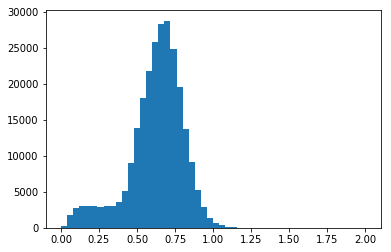

In [224]:
rng = np.random.RandomState(42)
subsample_idx = rng.randint(0, all_test_voxels.size - 1, size=int(1e6))
test_voxels_subsample = all_test_voxels[subsample_idx] 
plt.hist(test_voxels_subsample, range=(1e-6, 2), bins=50);

In [225]:
vmin, vmax = np.percentile(test_voxels_subsample, [0, 99.9])
vmin, vmax

(0.0, 1.0154318112135015)

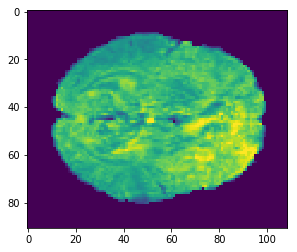

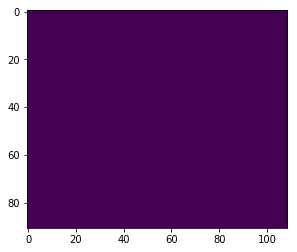

In [226]:
frame_idx = 0
channel_idx = 0
cut_idx = 40

plt.figure()
plt.imshow(test_data[frame_idx, channel_idx, :, :, cut_idx], vmax=vmax);
plt.figure()
plt.imshow(mean[channel_idx, :, :, cut_idx], vmax=vmax);

## Generate a movie of the test bold signal

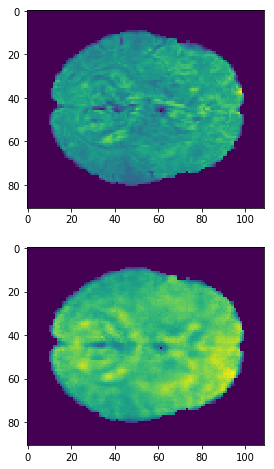

In [227]:
def make_animation(frames, interval=200, fig=None):
    if fig is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    im1 = ax1.imshow(frames[0][0], animated=True)
    im2 = ax2.imshow(frames[0][1], animated=True)

    def updatefig(frame):
        im1.set_array(frame[0])
        im2.set_array(frame[1])
        return im1, im2

    return animation.FuncAnimation(fig, updatefig, frames=frames,
                                   interval=interval, blit=True)


anim = make_animation(list(zip(data[:, channel_idx, :, :, cut_idx], rec[:, channel_idx, :, :, cut_idx])))

In [228]:
HTML(anim.to_html5_video())

# Latent space exploration

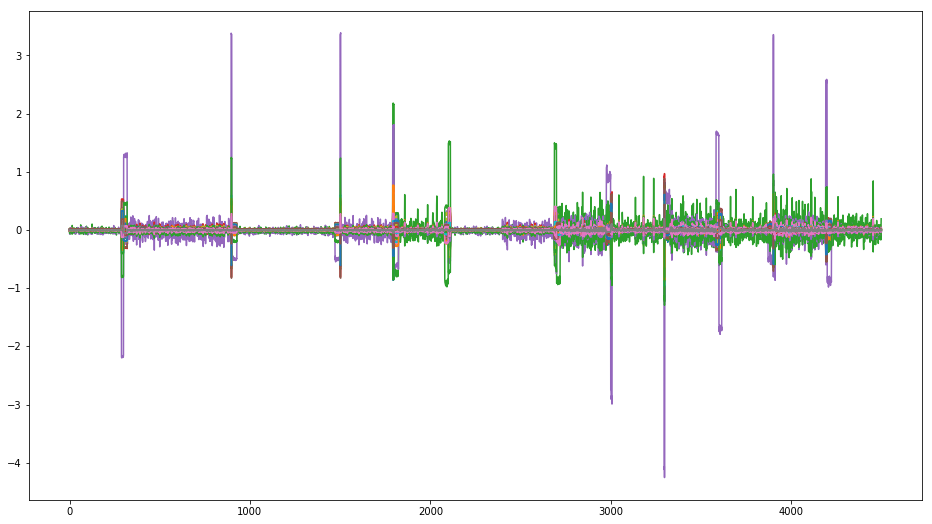

In [237]:
fig = plt.figure(figsize=(16, 9))
lines = plt.plot(range(len(latent)), latent)

In [ ]:
- loss / penalty reweight
- residual prediction
- downsampling + smoothing
- train comparison
